In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow numpy scipy


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

In [3]:
%config SqlMagic.autopandas = True
#%config SqlMagic.displaycon = False

In [4]:
%%sql
INSTALL sqlite;
LOAD sqlite;

Running query in 'duckdb'

,Success


In [5]:
%%sql
ATTACH '397027.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

Running query in 'duckdb'

,Success


In [6]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [7]:
%sql SHOW;

Running query in 'duckdb'

,database,schema,name,column_names,column_types,temporary


In [8]:
hej = %sql select message from expdb.Trace WHERE message LIKE 'TIMINGS>%'

Running query in 'duckdb'

In [9]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 805 ms, Load: 25 ms, sensor init: 25 ms, env init: 0 ms, net init: 156908 ms, Collect: -1 ms, Exec: -1 ms, Send: 7890 ms, save config: 704 ms, Sleep: 6 s\n'

In [10]:
%sql nodes =<< select distinct * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA75,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA74,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1
7,70B3D57ED005EA69,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA77,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [11]:
%%sql
DESCRIBE expdb.Trace

Running query in 'duckdb'

,column_name,column_type,null,key,default,extra


In [95]:
%%sql
select * from expdb.Power_Consumption WHERE node_id= '70B3D57ED005EA60' limit 5

Running query in 'duckdb'

,power_consumption_id,node_id,timestamp,current,voltage,power
0,6415573,70B3D57ED005EA60,2024-05-01 09:18:53.102287,0.057702,4.96500,0.286922
1,6415574,70B3D57ED005EA60,2024-05-01 09:18:53.103416,0.057873,4.96125,0.286922
2,6415575,70B3D57ED005EA60,2024-05-01 09:18:53.104546,0.057775,4.96375,0.286922
3,6415576,70B3D57ED005EA60,2024-05-01 09:18:53.105644,0.058044,4.96250,0.288143
4,6415577,70B3D57ED005EA60,2024-05-01 09:18:53.106773,0.058263,4.96250,0.289363


In [12]:

timestamps= %sql select timestamp from expdb.Power_Consumption 
timestamps

Running query in 'duckdb'

,timestamp
0,2024-05-01 09:18:53.146809
1,2024-05-01 09:18:53.147938
2,2024-05-01 09:18:53.149067
3,2024-05-01 09:18:53.150196
4,2024-05-01 09:18:53.151355
...,...
20349159,2024-05-01 09:38:59.540484
20349160,2024-05-01 09:38:59.541644
20349161,2024-05-01 09:38:59.542773
20349162,2024-05-01 09:38:59.543932


In [13]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from expdb.Power_Consumption group by node_id

Running query in 'duckdb'

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA75,1088531,2024-05-01 09:18:52.956537,2024-05-01 09:38:59.550481
1,70B3D57ED005EA61,1078176,2024-05-01 09:18:53.266367,2024-05-01 09:38:59.544461
2,70B3D57ED005EA65,1061704,2024-05-01 09:18:53.146809,2024-05-01 09:38:59.543907
3,70B3D57ED005EA71,1071829,2024-05-01 09:18:53.115694,2024-05-01 09:38:59.540682
4,70B3D57ED005EA60,1074085,2024-05-01 09:18:53.102287,2024-05-01 09:38:59.535514
5,70B3D57ED005EA72,1074339,2024-05-01 09:18:53.101671,2024-05-01 09:38:59.544753
6,70B3D57ED005EA68,1068376,2024-05-01 09:18:53.279690,2024-05-01 09:38:59.536698
7,70B3D57ED005EA67,1072836,2024-05-01 09:18:53.898859,2024-05-01 09:38:59.546379
8,70B3D57ED005EA69,1075886,2024-05-01 09:18:53.267282,2024-05-01 09:38:59.536220
9,70B3D57ED005EA73,1085936,2024-05-01 09:18:52.983802,2024-05-01 09:38:59.549093


In [14]:
deveui = "70B3D57ED005EA59"

power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
groups.groups.keys()

Running query in 'duckdb'

dict_keys(['70B3D57ED005EA59', '70B3D57ED005EA60', '70B3D57ED005EA61', '70B3D57ED005EA62', '70B3D57ED005EA63', '70B3D57ED005EA65', '70B3D57ED005EA66', '70B3D57ED005EA67', '70B3D57ED005EA68', '70B3D57ED005EA69', '70B3D57ED005EA70', '70B3D57ED005EA71', '70B3D57ED005EA72', '70B3D57ED005EA73', '70B3D57ED005EA74', '70B3D57ED005EA75', '70B3D57ED005EA76', '70B3D57ED005EA77', '70B3D57ED005EA78'])

/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


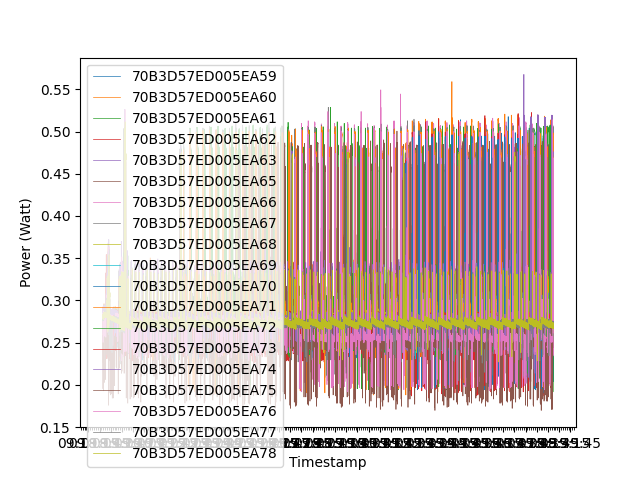

In [15]:
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

In [16]:
groups["power"].get_group(deveui)

timestamp
2024-05-01 09:18:53.119677    0.281427
2024-05-01 09:18:53.120775    0.280206
2024-05-01 09:18:53.121904    0.281427
2024-05-01 09:18:53.123003    0.281427
2024-05-01 09:18:53.124101    0.282038
                                ...   
2024-05-01 09:38:59.534442    0.257008
2024-05-01 09:38:59.535541    0.257008
2024-05-01 09:38:59.536639    0.255788
2024-05-01 09:38:59.537768    0.256398
2024-05-01 09:38:59.538867    0.257008
Name: power, Length: 1087308, dtype: float64

## finding sync signals

In [17]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


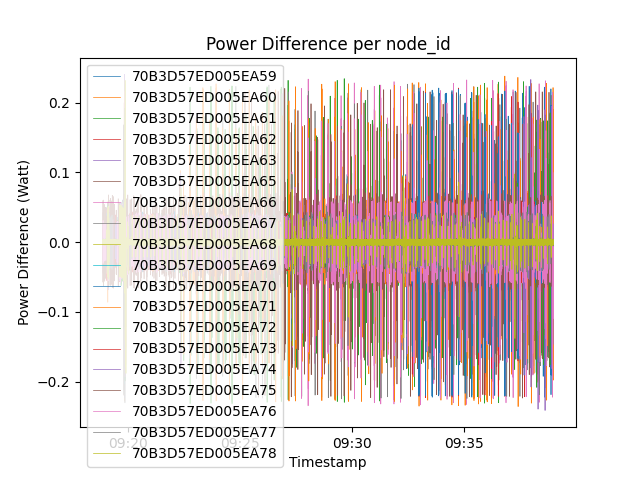

In [18]:
#diff of each group
power_consumption['power_diff'] = groups["power"].diff()

# single node
power_single = power_consumption[(power_consumption["node_id"] ==deveui)]
plt.figure()
for node_id, group in power_consumption.groupby("node_id"):
    plt.plot(group.index, group["power_diff"], label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

In [19]:
rising_edge = power_consumption[power_consumption["power_diff"] > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-05-01 09:19:50.085919,0.503028,0.101582,4.95000,70B3D57ED005EA67,0.160554,rising
2024-05-01 09:19:50.131690,0.435266,0.090521,4.80875,70B3D57ED005EA65,0.167880,rising
2024-05-01 09:19:50.285939,0.278985,0.056212,4.96000,70B3D57ED005EA67,-0.218549,falling
2024-05-01 09:19:50.331679,0.377882,0.078482,4.81500,70B3D57ED005EA65,-0.105001,falling
2024-05-01 09:19:50.332808,0.264334,0.054869,4.81625,70B3D57ED005EA65,-0.113548,falling


In [20]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation
edges['timestamp'] = edges.index.copy()
edges['next_direction'] = edges.groupby('node_id')['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id')['timestamp'].shift(-1)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-05-01 09:19:50.085919,0.503028,0.101582,4.95000,70B3D57ED005EA67,0.160554,rising,2024-05-01 09:19:50.085919,falling,2024-05-01 09:19:50.285939
2024-05-01 09:19:50.131690,0.435266,0.090521,4.80875,70B3D57ED005EA65,0.167880,rising,2024-05-01 09:19:50.131690,falling,2024-05-01 09:19:50.331679
2024-05-01 09:19:50.285939,0.278985,0.056212,4.96000,70B3D57ED005EA67,-0.218549,falling,2024-05-01 09:19:50.285939,rising,2024-05-01 09:19:50.488216
2024-05-01 09:19:50.331679,0.377882,0.078482,4.81500,70B3D57ED005EA65,-0.105001,falling,2024-05-01 09:19:50.331679,falling,2024-05-01 09:19:50.332808
2024-05-01 09:19:50.332808,0.264334,0.054869,4.81625,70B3D57ED005EA65,-0.113548,falling,2024-05-01 09:19:50.332808,rising,2024-05-01 09:19:50.535055


In [22]:
# now to filter out edges that are too close to each other or too far apart. We add 10% tolerance

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-05-01 09:19:50.085919,0.503028,0.101582,4.95000,70B3D57ED005EA67,0.160554,rising,2024-05-01 09:19:50.085919,falling,2024-05-01 09:19:50.285939
2024-05-01 09:19:50.131690,0.435266,0.090521,4.80875,70B3D57ED005EA65,0.167880,rising,2024-05-01 09:19:50.131690,falling,2024-05-01 09:19:50.331679
2024-05-01 09:19:50.488216,0.448697,0.090667,4.95125,70B3D57ED005EA67,0.168491,rising,2024-05-01 09:19:50.488216,falling,2024-05-01 09:19:50.688236
2024-05-01 09:19:50.535055,0.484104,0.100459,4.81500,70B3D57ED005EA65,0.159333,rising,2024-05-01 09:19:50.535055,falling,2024-05-01 09:19:50.735044
2024-05-01 09:19:51.092907,0.477389,0.099458,4.80375,70B3D57ED005EA62,0.199625,rising,2024-05-01 09:19:51.092907,falling,2024-05-01 09:19:51.292774


In [23]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-05-01 09:19:50.085919,0.503028,0.101582,4.95000,70B3D57ED005EA67,0.160554,rising,2024-05-01 09:19:50.085919,falling,2024-05-01 09:19:50.285939,2024-05-01 09:19:49.985919,2024-05-01 09:19:50.385939
2024-05-01 09:19:50.131690,0.435266,0.090521,4.80875,70B3D57ED005EA65,0.167880,rising,2024-05-01 09:19:50.131690,falling,2024-05-01 09:19:50.331679,2024-05-01 09:19:50.031690,2024-05-01 09:19:50.431679
2024-05-01 09:19:50.488216,0.448697,0.090667,4.95125,70B3D57ED005EA67,0.168491,rising,2024-05-01 09:19:50.488216,falling,2024-05-01 09:19:50.688236,2024-05-01 09:19:50.388216,2024-05-01 09:19:50.788236
2024-05-01 09:19:50.535055,0.484104,0.100459,4.81500,70B3D57ED005EA65,0.159333,rising,2024-05-01 09:19:50.535055,falling,2024-05-01 09:19:50.735044,2024-05-01 09:19:50.435055,2024-05-01 09:19:50.835044
2024-05-01 09:19:51.092907,0.477389,0.099458,4.80375,70B3D57ED005EA62,0.199625,rising,2024-05-01 09:19:51.092907,falling,2024-05-01 09:19:51.292774,2024-05-01 09:19:50.992907,2024-05-01 09:19:51.392774


Node 70B3D57ED005EA68 has no edges
Node 70B3D57ED005EA73 has no edges


/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


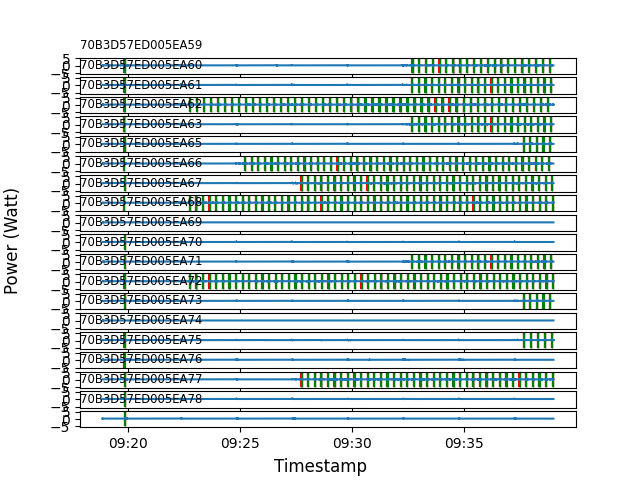

In [24]:
groups_by_node_id = power_consumption.groupby('node_id')
edges_by_node_id = edges.groupby('node_id')

fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained')

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in edges_by_node_id.groups:
        edges_grouped = edges_by_node_id.get_group(node_id)
        ax.vlines(edges_grouped['timestamp'], ymin=-5, ymax=5, color='red')
        ax.vlines(edges_grouped['next_timestamp'], ymin=-5, ymax=5, color='green')
        for row in edges_by_node_id.get_group(node_id).itertuples():
            ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)

    else:
        print(f"Node {node_id} has no edges")
    ax.plot(group.index, group["power"], label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')


plt.show()

In [25]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
grouped = edges.groupby('node_id')
edges['next_sync_start'] = grouped['sync_start'].shift(-1)
edges['next_sync_end'] = grouped['sync_end'].shift(-1)
loops = edges[abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500)][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = loops.groupby('node_id').cumcount()
loops[['node_id','loop_num']]


,node_id,loop_num
timestamp,,
2024-05-01 09:19:50.085919,70B3D57ED005EA67,0
2024-05-01 09:19:50.131690,70B3D57ED005EA65,0
2024-05-01 09:19:51.092907,70B3D57ED005EA62,0
2024-05-01 09:19:51.122922,70B3D57ED005EA75,0
2024-05-01 09:19:51.291411,70B3D57ED005EA61,0
...,...,...
2024-05-01 09:38:55.265973,70B3D57ED005EA74,5
2024-05-01 09:38:56.119532,70B3D57ED005EA66,39
2024-05-01 09:38:57.104255,70B3D57ED005EA76,39


Node 70B3D57ED005EA68 has no loops
Node 70B3D57ED005EA73 has no loops


/home/kasper/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


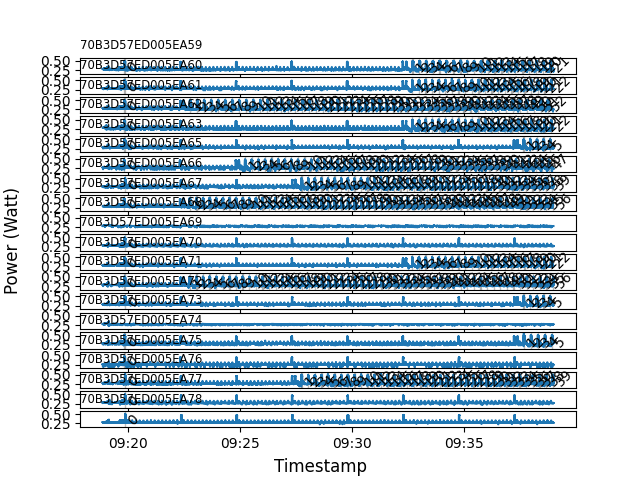

In [26]:

groups_by_node_id = power_consumption.groupby('node_id')
loops_by_node_id = loops.groupby('node_id')
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained')

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in loops_by_node_id.groups:
        loops_group = loops_by_node_id.get_group(node_id)
        for row in loops_group.itertuples():
            ax.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
            ax.text(row.loop_signal_end, 0.2, f"{row.loop_num}", rotation=45)
    else:
        print(f"Node {node_id} has no loops")
    ax.plot(group.index, group["power"], label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')

plt.show()

In [28]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: (-?[0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings['node_id'].unique()

Running query in 'duckdb'

array(['70B3D57ED005EA71', '70B3D57ED005EA67', '70B3D57ED005EA61',
       '70B3D57ED005EA65', '70B3D57ED005EA66', '70B3D57ED005EA76',
       '70B3D57ED005EA70', '70B3D57ED005EA60', '70B3D57ED005EA62',
       '70B3D57ED005EA59', '70B3D57ED005EA63', '70B3D57ED005EA72',
       '70B3D57ED005EA74'], dtype=object)

In [29]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-05-01 09:19:49.985919,2024-05-01 09:19:50.085919,70B3D57ED005EA67,2024-05-01 09:19:50.788236,0,2024-05-01 09:22:39.787173,805,25,25,0,158336,-1,-1,7890,705,6
2024-05-01 09:19:50.031690,2024-05-01 09:19:50.131690,70B3D57ED005EA65,2024-05-01 09:19:50.835044,0,2024-05-01 09:25:07.811483,806,25,25,0,306138,-1,-1,8073,699,6
2024-05-01 09:19:50.992907,2024-05-01 09:19:51.092907,70B3D57ED005EA62,2024-05-01 09:19:51.795987,0,2024-05-01 09:32:31.322125,805,25,25,0,752876,-1,-1,3890,702,10
2024-05-01 09:19:51.191411,2024-05-01 09:19:51.291411,70B3D57ED005EA61,2024-05-01 09:19:51.994429,0,2024-05-01 09:22:40.414665,805,25,25,0,157123,-1,-1,7894,1324,6
2024-05-01 09:19:51.361490,2024-05-01 09:19:51.461490,70B3D57ED005EA60,2024-05-01 09:19:52.164661,0,2024-05-01 09:32:31.320540,805,25,25,0,752515,-1,-1,3890,701,10


In [30]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["load_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["env_init_start"] = loops["sensor_init_end"]
loops["env_init_end"] = loops["env_init_start"] + pd.to_timedelta(loops["env_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["env_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available



,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,...,collect_time_start,collect_time_end,exec_start,exec_end,send_start,send_end,save_config_start,save_config_end,sleep_start,sleep_end
loop_signal_start,,,,,,,,,,,,,,,,,,,,,
2024-05-01 09:19:49.985919,2024-05-01 09:19:50.085919,70B3D57ED005EA67,2024-05-01 09:19:50.788236,0,2024-05-01 09:22:39.787173,805,25,25,0,158336,...,2024-05-01 09:22:29.176919,2024-05-01 09:22:29.175919,2024-05-01 09:22:29.175919,2024-05-01 09:22:29.174919,2024-05-01 09:22:29.174919,2024-05-01 09:22:37.064919,2024-05-01 09:22:37.064919,2024-05-01 09:22:37.769919,2024-05-01 09:22:37.769919,2024-05-01 09:22:43.769919
2024-05-01 09:19:50.031690,2024-05-01 09:19:50.131690,70B3D57ED005EA65,2024-05-01 09:19:50.835044,0,2024-05-01 09:25:07.811483,806,25,25,0,306138,...,2024-05-01 09:24:57.025690,2024-05-01 09:24:57.024690,2024-05-01 09:24:57.024690,2024-05-01 09:24:57.023690,2024-05-01 09:24:57.023690,2024-05-01 09:25:05.096690,2024-05-01 09:25:05.096690,2024-05-01 09:25:05.795690,2024-05-01 09:25:05.795690,2024-05-01 09:25:11.795690
2024-05-01 09:19:50.992907,2024-05-01 09:19:51.092907,70B3D57ED005EA62,2024-05-01 09:19:51.795987,0,2024-05-01 09:32:31.322125,805,25,25,0,752876,...,2024-05-01 09:32:24.723907,2024-05-01 09:32:24.722907,2024-05-01 09:32:24.722907,2024-05-01 09:32:24.721907,2024-05-01 09:32:24.721907,2024-05-01 09:32:28.611907,2024-05-01 09:32:28.611907,2024-05-01 09:32:29.313907,2024-05-01 09:32:29.313907,2024-05-01 09:32:39.313907
2024-05-01 09:19:51.191411,2024-05-01 09:19:51.291411,70B3D57ED005EA61,2024-05-01 09:19:51.994429,0,2024-05-01 09:22:40.414665,805,25,25,0,157123,...,2024-05-01 09:22:29.169411,2024-05-01 09:22:29.168411,2024-05-01 09:22:29.168411,2024-05-01 09:22:29.167411,2024-05-01 09:22:29.167411,2024-05-01 09:22:37.061411,2024-05-01 09:22:37.061411,2024-05-01 09:22:38.385411,2024-05-01 09:22:38.385411,2024-05-01 09:22:44.385411
2024-05-01 09:19:51.361490,2024-05-01 09:19:51.461490,70B3D57ED005EA60,2024-05-01 09:19:52.164661,0,2024-05-01 09:32:31.320540,805,25,25,0,752515,...,2024-05-01 09:32:24.731490,2024-05-01 09:32:24.730490,2024-05-01 09:32:24.730490,2024-05-01 09:32:24.729490,2024-05-01 09:32:24.729490,2024-05-01 09:32:28.619490,2024-05-01 09:32:28.619490,2024-05-01 09:32:29.320490,2024-05-01 09:32:29.320490,2024-05-01 09:32:39.320490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 09:38:44.064896,2024-05-01 09:38:44.164896,70B3D57ED005EA61,2024-05-01 09:38:44.867975,52,2024-05-01 09:38:52.706400,806,24,26,0,56,...,2024-05-01 09:38:44.976896,2024-05-01 09:38:44.976896,2024-05-01 09:38:44.976896,2024-05-01 09:38:45.096896,2024-05-01 09:38:45.096896,2024-05-01 09:38:49.127896,2024-05-01 09:38:49.127896,2024-05-01 09:38:50.389896,2024-05-01 09:38:50.389896,2024-05-01 09:39:00.389896
2024-05-01 09:38:47.108117,2024-05-01 09:38:47.208117,70B3D57ED005EA65,2024-05-01 09:38:47.910373,47,2024-05-01 09:38:54.652695,805,25,25,1,56,...,2024-05-01 09:38:48.020117,2024-05-01 09:38:48.019117,2024-05-01 09:38:48.019117,2024-05-01 09:38:48.018117,2024-05-01 09:38:48.018117,2024-05-01 09:38:52.097117,2024-05-01 09:38:52.097117,2024-05-01 09:38:52.630117,2024-05-01 09:38:52.630117,2024-05-01 09:39:02.630117
2024-05-01 09:38:50.087803,2024-05-01 09:38:50.187803,70B3D57ED005EA63,2024-05-01 09:38:50.891005,5,2024-05-01 09:38:57.630685,806,24,25,0,56,...,2024-05-01 09:38:50.998803,2024-05-01 09:38:50.997803,2024-05-01 09:38:50.997803,2024-05-01 09:38:50.996803,2024-05-01 09:38:50.996803,2024-05-01 09:38:55.074803,2024-05-01 09:38:55.074803,2024-05-01 09:38:55.605803,2024-05-01 09:38:55.605803,2024-05-01 09:39:05.605803


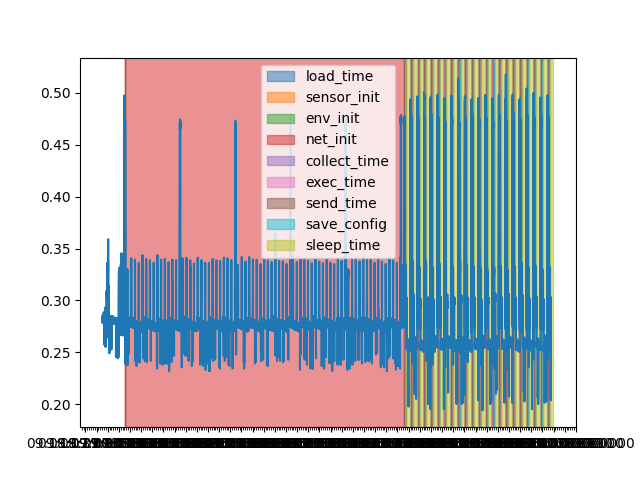

In [31]:
node_id = "70B3D57ED005EA59"
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data.index, power_data["power"])
for row in timing_data.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.env_init_start, row.env_init_end, color='tab:green', alpha=0.5, label="env_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()


## Add events if any

In [32]:
# get all relevant frame-events
%sql send_frame_start << select * from expdb.Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from expdb.Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from expdb.Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from expdb.Trace WHERE message LIKE '%received something%'

print(f"{len(send_frame_start)} send frame start events. {len(send_frame_end)} end events. {len(receive_frame_start)} receive frame start events. {len(receive_frame_end)} end events.")

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

0 send frame start events. 0 end events. 0 receive frame start events. 0 end events.


In [34]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

In [33]:
# add send and receive columns to plot
#TODO: update this to support more nodes
# for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
#     start_time = send_start_row.timestamp
#     end_time = send_end_row.timestamp
#     plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

# for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
#     start_time = receive_frame_start.timestamp
#     end_time = receive_frame_end.timestamp
#     plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [35]:
%sql SELECT * from expdb.Content_Message

Running query in 'duckdb'

,content_message_id,frame_counter,frame_port,frame_payload
0,1,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
1,2,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
2,3,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
3,4,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
4,5,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
...,...,...,...,...
210,223,38,2,PDM=
211,224,52,2,Cg4SAyD2ExIDIJQoEgJABg==
212,225,47,2,PDM=
213,226,21,2,Cg4SAyDiExIDIOAmEgJABg==


In [36]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

Running query in 'duckdb'

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,iot-lab-saclay-gateway,2024-05-01 09:22:30,2024-05-01 09:22:30.851659,-31,8.25,125000,867700000,1.155072,SF12,4/5,0,2,PDM=,"[60, 51]",70B3D57ED005EA61,2024-05-01 09:22:30.641768
1,gw-tetech-test,2024-05-01 09:22:49,2024-05-01 09:22:49.798867,-124,-9.00,125000,868100000,1.646592,SF12,4/5,1,2,Cg4SAyC6ExIDIJYpEgJABg==,"[10, 14, 18, 3, 32, 186, 19, 18, 3, 32, 150, 4...",70B3D57ED005EA61,2024-05-01 09:22:49.593486
2,iot-lab-saclay-gateway,2024-05-01 09:23:08,2024-05-01 09:23:08.685634,-101,-7.75,125000,867100000,1.646592,SF12,4/5,2,2,Cg4SAyC6ExIDIJYpEgJABg==,"[10, 14, 18, 3, 32, 186, 19, 18, 3, 32, 150, 4...",70B3D57ED005EA61,2024-05-01 09:23:08.481406
3,gw-tetech-test,2024-05-01 09:23:27,2024-05-01 09:23:27.341254,-115,-15.80,125000,868100000,1.646592,SF12,4/5,3,2,Cg4SAyC6ExIDIJYpEgJABg==,"[10, 14, 18, 3, 32, 186, 19, 18, 3, 32, 150, 4...",70B3D57ED005EA61,2024-05-01 09:23:27.136931
4,iot-lab-saclay-gateway,2024-05-01 09:23:46,2024-05-01 09:23:46.243238,-29,10.50,125000,868300000,1.646592,SF12,4/5,4,2,Cg4SAyC6ExIDIIwpEgJABg==,"[10, 14, 18, 3, 32, 186, 19, 18, 3, 32, 140, 4...",70B3D57ED005EA61,2024-05-01 09:23:46.035633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,gw-tetech-test,2024-05-01 09:35:20,2024-05-01 09:35:20.787614,-124,-8.20,125000,868100000,1.646592,SF12,4/5,41,2,Cg4SAyDsExIDIKgoEgJABg==,"[10, 14, 18, 3, 32, 236, 19, 18, 3, 32, 168, 4...",70B3D57ED005EA61,2024-05-01 09:35:20.578978
153,gw-tetech-test,2024-05-01 09:35:48,2024-05-01 09:35:48.293528,-115,-16.20,125000,868100000,1.646592,SF12,4/5,11,2,Cg4SAyDiExIDIOomEgJABg==,"[10, 14, 18, 3, 32, 226, 19, 18, 3, 32, 234, 3...",70B3D57ED005EA59,2024-05-01 09:35:48.085479
154,iot-lab-saclay-gateway,2024-05-01 09:37:13,2024-05-01 09:37:13.526938,-29,10.25,125000,868300000,1.646592,SF12,4/5,47,2,Cg4SAyD2ExIDIJ4oEgJABg==,"[10, 14, 18, 3, 32, 246, 19, 18, 3, 32, 158, 4...",70B3D57ED005EA61,2024-05-01 09:37:13.319431
155,iot-lab-saclay-gateway,2024-05-01 09:37:51,2024-05-01 09:37:51.078485,-29,13.00,125000,868300000,1.646592,SF12,4/5,49,2,Cg4SAyD2ExIDIJQoEgJABg==,"[10, 14, 18, 3, 32, 246, 19, 18, 3, 32, 148, 4...",70B3D57ED005EA61,2024-05-01 09:37:50.873266


## experiment stats
with sync signals and events mapped we can see some stats on the experiments

In [37]:
%%sql
select * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1


In [38]:
loops.groupby('node_id')['loop_num'].max()

node_id
70B3D57ED005EA59    21
70B3D57ED005EA60    21
70B3D57ED005EA61    52
70B3D57ED005EA62    21
70B3D57ED005EA63     5
70B3D57ED005EA65    47
70B3D57ED005EA66    38
70B3D57ED005EA67    55
70B3D57ED005EA70    21
70B3D57ED005EA71    55
70B3D57ED005EA72     5
70B3D57ED005EA74     4
70B3D57ED005EA76    38
Name: loop_num, dtype: int64

## Calculate Total Energy Consumed per region

In [39]:
np.sum((np.abs(np.diff(power_consumption.index.to_numpy())) / np.timedelta64(1, 's')) * power_consumption["power"].values[:-1])

12801.391564770009

In [40]:
#define function to calculate energy consumed

def calc_energy_consumed(df: pd.DataFrame):

    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
        # ensure we only calculate for data frames containing data from a single node
    assert len(df["node_id"].unique()) == 1, "energy consumption only supported for single node"

    # assert df have columns "power" and index of "timestamp" type
    assert "power" in df.columns, "power column not found"
    assert isinstance(df.index, pd.DatetimeIndex), "index is not  of type pd.DatetimeIndex"
    times = df.index.array
    powers = df["power"].values

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    time_diff= np.abs(np.diff(times)) # abs(next-current)
    time_diff_s = time_diff / np.timedelta64(1, 's') # get timediff in fractions of a second
    powers = powers[:-1] # drop last row since it has no next and doesnt match up with the time_diff
    return np.sum(powers * time_diff_s) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J


In [41]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    power_consumption_for_node = power_consumption[(power_consumption["node_id"] == series_loops["node_id"])]
    return pd.Series({
        "node_id": series_loops["node_id"],
        "loop_num": series_loops["loop_num"],
        "total": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "sensor init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "env init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["env_init_start"]:series_loops["env_init_end"]]),
        "net init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_consumption_for_node.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_consumption_for_node.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.0,396.000000,396.0,396.000000,396.000000,396.000000,396.000000
mean,20.282828,10.080054,0.309589,9.770146,0.006631,0.006978,0.0,5.561290,0.0,0.006755,1.430113,0.189579,2.566663
std,14.791404,34.566951,0.004840,34.566564,0.000169,0.000246,0.0,34.550029,0.0,0.013767,0.168810,0.082132,0.218691
min,0.000000,2.947738,0.296852,2.633874,0.006290,0.006607,0.0,0.015094,0.0,0.000000,1.174732,0.139875,0.787035
25%,8.000000,4.460260,0.307614,4.151666,0.006507,0.006765,0.0,0.015812,0.0,0.000000,1.381150,0.146447,2.585998
50%,18.000000,4.503395,0.309868,4.189205,0.006628,0.006966,0.0,0.015962,0.0,0.000000,1.391209,0.148135,2.613293
75%,31.250000,4.594546,0.312819,4.281002,0.006723,0.007097,0.0,0.016167,0.0,0.000000,1.421546,0.152276,2.640405
max,55.000000,302.389081,0.320974,302.069125,0.007225,0.007688,0.0,297.524892,0.0,0.035707,2.523446,0.392559,2.700934


In [42]:
import scipy.stats as st
def calc_confidence_interval(series: pd.Series) -> pd.Series:
    assert "mean" in series.index, "mean not in index"
    assert "std" in series.index, "std not in index"
    low, high = st.norm.interval(0.95, loc=series["mean"], scale=series["std"])
    return pd.Series({
        "low": low,
        "high": high
    })



In [55]:
energy_consumed_summary

,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.0,396.000000,396.0,396.000000,396.000000,396.000000,396.000000
mean,20.282828,10.080054,0.309589,9.770146,0.006631,0.006978,0.0,5.561290,0.0,0.006755,1.430113,0.189579,2.566663
std,14.791404,34.566951,0.004840,34.566564,0.000169,0.000246,0.0,34.550029,0.0,0.013767,0.168810,0.082132,0.218691
min,0.000000,2.947738,0.296852,2.633874,0.006290,0.006607,0.0,0.015094,0.0,0.000000,1.174732,0.139875,0.787035
25%,8.000000,4.460260,0.307614,4.151666,0.006507,0.006765,0.0,0.015812,0.0,0.000000,1.381150,0.146447,2.585998
50%,18.000000,4.503395,0.309868,4.189205,0.006628,0.006966,0.0,0.015962,0.0,0.000000,1.391209,0.148135,2.613293
75%,31.250000,4.594546,0.312819,4.281002,0.006723,0.007097,0.0,0.016167,0.0,0.000000,1.421546,0.152276,2.640405
max,55.000000,302.389081,0.320974,302.069125,0.007225,0.007688,0.0,297.524892,0.0,0.035707,2.523446,0.392559,2.700934


In [68]:
def hej(row: pd.Series):
    primary = list(set(k[0] for k in row.keys()))
    return calc_confidence_interval(row[primary[0]])

grouped_agg.apply(hej, axis=1)

,low,high
node_id,,
70B3D57ED005EA59,0.015693,0.016051
70B3D57ED005EA60,0.015662,0.016270
70B3D57ED005EA61,0.015704,0.016004
70B3D57ED005EA62,0.015695,0.016213
70B3D57ED005EA63,0.015813,0.016278
70B3D57ED005EA65,0.015018,0.015562
70B3D57ED005EA66,0.015871,0.016282
70B3D57ED005EA67,0.016185,0.016506
70B3D57ED005EA70,0.015555,0.015855


In [43]:
errors = energy_consumed_summary.apply(calc_confidence_interval)
errors = np.abs(errors)
errors

/home/kasper/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/kasper/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
low,8.707791,57.669925,0.300102,57.979074,0.006300,0.006496,NaN,62.155523,NaN,0.020228,1.099251,0.028604,2.138037
high,49.273447,77.830032,0.319075,77.519365,0.006961,0.007460,NaN,73.278103,NaN,0.033737,1.760976,0.350555,2.995289


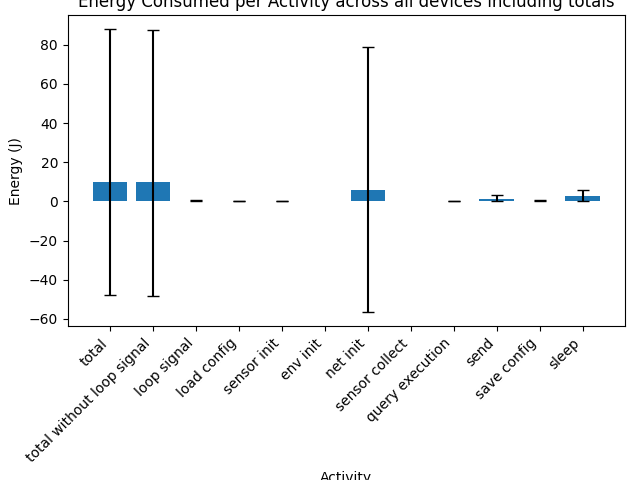

In [44]:
# plot barchart with stddev error bars
plt.figure()
to_plot = energy_consumed_summary[["total", "total without loop signal", "loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
errors = errors[["total", "total without loop signal", "loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors,capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices including totals")
plt.show()

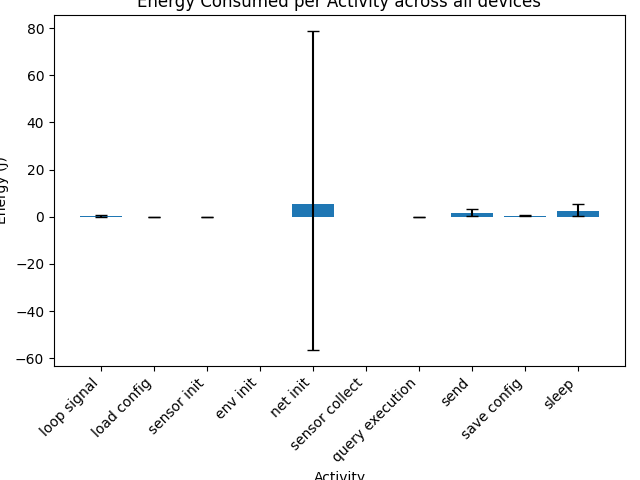

In [45]:
# plot barchart without totals 
plt.figure()
to_plot = energy_consumed_summary[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
errors = errors[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices")
plt.show()

In [46]:
# plot barchart without totals and without the 0th loop
# recalc summary without 0 loops
without_0th_loop = loops[loops["loop_num"] > 0].apply(calc_energy_consumed_per_activity, axis=1)
without_0th_loop_summary = without_0th_loop.describe()

In [47]:
errors_with_0th_loop = without_0th_loop_summary.apply(calc_confidence_interval)
errors_with_0th_loop = np.abs(errors_with_0th_loop)
errors_with_0th_loop

/home/kasper/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/kasper/.local/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
low,7.549781,4.104788,0.300067,3.798536,0.006311,0.006493,NaN,0.015320,NaN,0.020341,1.303722,0.027572,2.269444
high,49.492339,4.958445,0.319017,4.644973,0.006929,0.007465,NaN,0.016551,NaN,0.034309,1.508343,0.348517,2.908568


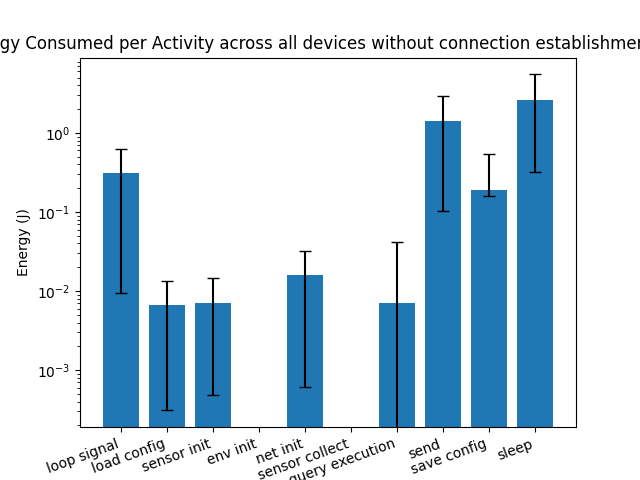

In [48]:
to_plot = without_0th_loop_summary[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
errors = errors_with_0th_loop[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
#energy_consumed_without_0th_loop
plt.figure()
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors, capsize=4, log=True)
plt.xticks(rotation=20, ha="right")

plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices without connection establishment loop")
plt.show()

In [49]:
without_0th_loop.groupby("node_id").describe()

loop_num                                                  \
                    count  mean        std  min    25%   50%    75%   max   
node_id                                                                     
70B3D57ED005EA59     21.0  11.0   6.204837  1.0   6.00  11.0  16.00  21.0   
70B3D57ED005EA60     21.0  11.0   6.204837  1.0   6.00  11.0  16.00  21.0   
70B3D57ED005EA61     52.0  26.5  15.154757  1.0  13.75  26.5  39.25  52.0   
70B3D57ED005EA62     21.0  11.0   6.204837  1.0   6.00  11.0  16.00  21.0   
70B3D57ED005EA63      5.0   3.0   1.581139  1.0   2.00   3.0   4.00   5.0   
70B3D57ED005EA65     47.0  24.0  13.711309  1.0  12.50  24.0  35.50  47.0   
70B3D57ED005EA66     38.0  19.5  11.113055  1.0  10.25  19.5  28.75  38.0   
70B3D57ED005EA67     55.0  28.0  16.020820  1.0  14.50  28.0  41.50  55.0   
70B3D57ED005EA70     21.0  11.0   6.204837  1.0   6.00  11.0  16.00  21.0   
70B3D57ED005EA71     55.0  28.0  16.020820  1.0  14.50  28.0  41.50  55.0   
70B3D57ED005EA72      5.0   3.0   1.581139  1.0   2.00   3.0   4.00   5.0   
70B3D57ED005EA74      4.0   2.5   1.290994  1.0   1.75   2.5   3.25   4.0   
70B3D57ED005EA76     38.0  19.5  11.113055  1.0  10.25  19.5  28.75  38.0   

                 total            ... save config           sleep            \
                 count      mean  ...         75%       max count      mean   
node_id                           ...                                         
70B3D57ED005EA59  21.0  4.695182  ...    0.363305  0.367036  21.0  2.451497   
70B3D57ED005EA60  21.0  4.564756  ...    0.150185  0.151248  21.0  2.651251   
70B3D57ED005EA61  52.0  4.826839  ...    0.348896  0.351573  52.0  2.618285   
70B3D57ED005EA62  21.0  4.470058  ...    0.147794  0.149109  21.0  2.601330   
70B3D57ED005EA63   5.0  4.214789  ...    0.148292  0.149001   5.0  2.323465   
70B3D57ED005EA65  47.0  4.294054  ...    0.141564  0.141893  47.0  2.480694   
70B3D57ED005EA66  38.0  4.504531  ...    0.148293  0.149176  38.0  2.631996   
70B3D57ED005EA67  55.0  4.582863  ...    0.151950  0.152923  55.0  2.672075   
70B3D57ED005EA70  21.0  4.447371  ...    0.146286  0.146744  21.0  2.592651   
70B3D57ED005EA71  55.0  4.463304  ...    0.146948  0.147795  55.0  2.588917   
70B3D57ED005EA72   5.0  4.219603  ...    0.149599  0.150424   5.0  2.326989   
70B3D57ED005EA74   4.0  4.919296  ...    0.352628  0.353318   4.0  2.689893   
70B3D57ED005EA76  38.0  4.487040  ...    0.148262  0.149177  38.0  2.611374   

                                                                              
                       std       min       25%       50%       75%       max  
node_id                                                                       
70B3D57ED005EA59  0.402097  0.787035  2.392800  2.633308  2.646559  2.670834  
70B3D57ED005EA60  0.017791  2.624804  2.633572  2.654302  2.664064  2.680346  
70B3D57ED005EA61  0.031413  2.407191  2.614334  2.623352  2.626549  2.641094  
70B3D57ED005EA62  0.016842  2.574742  2.586264  2.602976  2.613678  2.628626  
70B3D57ED005EA63  0.700152  1.071182  2.623242  2.629037  2.638744  2.655119  
70B3D57ED005EA65  0.112445  1.731634  2.482592  2.501786  2.509912  2.514353  
70B3D57ED005EA66  0.012799  2.611011  2.623003  2.630004  2.642459  2.654647  
70B3D57ED005EA67  0.007260  2.659791  2.665896  2.671686  2.678234  2.684923  
70B3D57ED005EA70  0.006215  2.581964  2.589362  2.591066  2.598548  2.602548  
70B3D57ED005EA71  0.005770  2.579674  2.584575  2.587067  2.592762  2.601715  
70B3D57ED005EA72  0.710680  1.055833  2.628961  2.640730  2.652965  2.656457  
70B3D57ED005EA74  0.011029  2.678163  2.681781  2.690238  2.698351  2.700934  
70B3D57ED005EA76  0.005767  2.601744  2.606982  2.609999  2.614091  2.623082  

[13 rows x 104 columns]

In [92]:
## plot per node
grouped = without_0th_loop[["node_id","loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] \
    .groupby("node_id")
grouped_agg = grouped.agg(["mean", "std"])
grouped_agg.apply
# print(grouped_agg.T.apply(lambda x: print(x.index)))
# # for (name, group) in grouped_agg:
# #     print(f"{name}: {group}")

# grouped.mean().T.plot(kind="bar",
#           title="Energy Consumed per Activity per device without connection establishment loop",
#           ylabel="Energy (J)",
#           xlabel="Activity",
#          yerr=grouped.std().T,
#           capsize=2,
#           logy=True,
#           rot=45,
#           log=True)
# plt.figure()
# # for name, group in grouped:
# #     print(name)
# #     gg = group.describe()
# #     plt.bar(gg.columns, gg.loc["mean"], yerr=gg.loc["std"], capsize=4, log=True)
# # plt.xticks(rotation=20, ha="right")

# # plt.xlabel("Activity")
# # plt.ylabel("Energy (J)")
# # plt.title("Energy Consumed per Activity across all devices without connection establishment loop")
# # plt.show()

#TODO: vis distribution over query execution means
# IFT: 2 modaliteter: selectivity på filtre. lav exp med forskl. selectivity og regression til cost model
# størrelse af query: save cost afhænger af query størrelse


loop signal           load config           sensor init  \
                        mean       std        mean       std        mean   
node_id                                                                    
70B3D57ED005EA59    0.308768  0.001408    0.006500  0.000041    0.007463   
70B3D57ED005EA60    0.316927  0.001923    0.006645  0.000051    0.007538   
70B3D57ED005EA61    0.310721  0.001114    0.006586  0.000156    0.007123   
70B3D57ED005EA62    0.307643  0.001876    0.006730  0.000153    0.007016   
70B3D57ED005EA63    0.309817  0.001571    0.006681  0.000034    0.007205   
70B3D57ED005EA65    0.299702  0.001454    0.006444  0.000144    0.006703   
70B3D57ED005EA66    0.313595  0.001457    0.006714  0.000041    0.006687   
70B3D57ED005EA67    0.313752  0.001267    0.006696  0.000032    0.007028   
70B3D57ED005EA70    0.305680  0.001000    0.006560  0.000026    0.006972   
70B3D57ED005EA71    0.308518  0.001038    0.006507  0.000058    0.006793   
70B3D57ED005EA72    0.313833  0.001198    0.006925  0.000033    0.007196   
70B3D57ED005EA74    0.318843  0.001540    0.006856  0.000048    0.007147   
70B3D57ED005EA76    0.309386  0.001157    0.006794  0.000169    0.006942   

                           env init       net init           sensor collect  \
                       std     mean  std      mean       std           mean   
node_id                                                                       
70B3D57ED005EA59  0.000045      0.0  0.0  0.015872  0.000091            0.0   
70B3D57ED005EA60  0.000140      0.0  0.0  0.015966  0.000155            0.0   
70B3D57ED005EA61  0.000036      0.0  0.0  0.015854  0.000077            0.0   
70B3D57ED005EA62  0.000060      0.0  0.0  0.015954  0.000132            0.0   
70B3D57ED005EA63  0.000186      0.0  0.0  0.016045  0.000119            0.0   
70B3D57ED005EA65  0.000040      0.0  0.0  0.015290  0.000139            0.0   
70B3D57ED005EA66  0.000044      0.0  0.0  0.016076  0.000105            0.0   
70B3D57ED005EA67  0.000034      0.0  0.0  0.016346  0.000082            0.0   
70B3D57ED005EA70  0.000135      0.0  0.0  0.015705  0.000076            0.0   
70B3D57ED005EA71  0.000036      0.0  0.0  0.015948  0.000079            0.0   
70B3D57ED005EA72  0.000034      0.0  0.0  0.016120  0.000082            0.0   
70B3D57ED005EA74  0.000042      0.0  0.0  0.016280  0.000111            0.0   
70B3D57ED005EA76  0.000033      0.0  0.0  0.016153  0.000102            0.0   

                      query execution                send            \
                  std            mean       std      mean       std   
node_id                                                               
70B3D57ED005EA59  0.0        0.034909  0.000268  1.508217  0.068241   
70B3D57ED005EA60  0.0        0.000000  0.000000  1.414656  0.008302   
70B3D57ED005EA61  0.0        0.034622  0.000174  1.482841  0.004967   
70B3D57ED005EA62  0.0        0.000000  0.000000  1.382362  0.009044   
70B3D57ED005EA63  0.0        0.000000  0.000000  1.401392  0.005665   
70B3D57ED005EA65  0.0        0.000000  0.000000  1.342392  0.005874   
70B3D57ED005EA66  0.0        0.000000  0.000000  1.379204  0.034721   
70B3D57ED005EA67  0.0        0.000000  0.000000  1.413196  0.029819   
70B3D57ED005EA70  0.0        0.000000  0.000000  1.371656  0.003580   
70B3D57ED005EA71  0.0        0.000000  0.000000  1.387671  0.003841   
70B3D57ED005EA72  0.0        0.000000  0.000000  1.397437  0.005507   
70B3D57ED005EA74  0.0        0.035380  0.000353  1.490763  0.008007   
70B3D57ED005EA76  0.0        0.000000  0.000000  1.386343  0.003962   

                 save config               sleep            
                        mean       std      mean       std  
node_id                                                     
70B3D57ED005EA59    0.358862  0.006539  2.451497  0.402097  
70B3D57ED005EA60    0.149341  0.001154  2.651251  0.017791  
70B3D57ED005EA61    0.347621  0.001822  2.618285  0.031413  
70B3D57ED005EA62    0.146723  0.